<a href="https://colab.research.google.com/github/silverCore97/IML/blob/main/Kopie_von__IML_Task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = "/content/drive/MyDrive/Colab Notebooks/SolarML/" 

pretrain_features_path = PATH + "pretrain_features.csv"
pretrain_labels_path = PATH + "pretrain_labels.csv"
test_features_path = PATH + "test_features.csv"
train_features_path = PATH + "train_features.csv"
train_labels_path = PATH + "train_labels.csv"
result_path = PATH + "result.csv"
elev_train_data_path = PATH + "elevated_train_labels.csv"

In [6]:
pretrain_features = pd.read_csv(pretrain_features_path)
pretrain_labels = pd.read_csv(pretrain_labels_path)
test_features = pd.read_csv(test_features_path)
train_features = pd.read_csv(train_features_path)
train_labels = pd.read_csv(train_labels_path)



In [7]:
x_pretrain_data = pretrain_features.drop(["Id", "smiles"], axis=1).to_numpy()
y_pretrain_data = pretrain_labels.drop(["Id"], axis=1).to_numpy()

x_train_data = train_features.drop(["Id", "smiles"], axis=1).to_numpy()
y_train_data = train_labels.drop(["Id"], axis=1).to_numpy()

x_test_data = test_features.drop(["Id", "smiles"], axis=1).to_numpy()



In [8]:
input_shape = x_pretrain_data.shape[1:]

pretrained_model = Sequential([
                               Dense(1024, activation="relu", input_shape=input_shape),
                               Dropout(0.2),
                               Dense(512, activation="relu"),
                               Dropout(0.2),
                               Dense(256, activation="relu"),
                               Dropout(0.2),
                               Dense(128, activation="relu"),
                               Dropout(0.2),
                               Dense(64, activation="relu"),
                               Dense(units=1, activation="linear")

])

In [9]:
pretrained_model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
pretrained_model.fit(x_pretrain_data, y_pretrain_data, validation_split=0.2, batch_size=50, epochs=20)

Epoch 1/20
800/800 [==============================] - 6s 3ms/step - loss: 0.1824 - val_loss: 0.6926
Epoch 2/20
800/800 [==============================] - 3s 3ms/step - loss: 0.0412 - val_loss: 0.2591
Epoch 3/20
800/800 [==============================] - 3s 3ms/step - loss: 0.0195 - val_loss: 0.1091
Epoch 4/20
800/800 [==============================] - 3s 4ms/step - loss: 0.0115 - val_loss: 0.0615
Epoch 5/20
800/800 [==============================] - 3s 3ms/step - loss: 0.0084 - val_loss: 0.0372
Epoch 6/20
800/800 [==============================] - 3s 3ms/step - loss: 0.0066 - val_loss: 0.0277
Epoch 7/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0056 - val_loss: 0.0198
Epoch 8/20
800/800 [==============================] - 3s 4ms/step - loss: 0.0052 - val_loss: 0.0192
Epoch 9/20
800/800 [==============================] - 3s 3ms/step - loss: 0.0048 - val_loss: 0.0165
Epoch 10/20
800/800 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0126

In [10]:
elev_train_data= train_labels.drop(["Id"], axis=1)
def create_elevated_train_labels():
  # Elevate train_labels by adding lumo_level
  train_lumo_level = pretrained_model.predict(x_train_data)
  elev_train_data["lumo_level"] = [lumo_level[0] for lumo_level in train_lumo_level]

  # calculate humo level in train_labels
  elev_train_data["homo_level"] = elev_train_data["lumo_level"] - elev_train_data["homo_lumo_gap"]
  elev_train_data.iloc[1:]
  print(elev_train_data)

  # create new csv called elevated_train_labels.csv
  elev_train_data.to_csv(elev_train_data_path, index=False)
  
create_elevated_train_labels()
elev_train_data = pd.read_csv(elev_train_data_path)
y_elev_train_data = elev_train_data["homo_level"].to_numpy()

    homo_lumo_gap  lumo_level  homo_level
0        2.052872   -2.993576   -5.046448
1        1.325530   -3.784492   -5.110022
2        1.837294   -3.094560   -4.931854
3        1.388601   -3.589575   -4.978177
4        0.991851   -3.698090   -4.689942
..            ...         ...         ...
95       1.791795   -2.851019   -4.642814
96       1.115060   -3.702835   -4.817896
97       2.087200   -3.135455   -5.222655
98       1.622947   -3.700507   -5.323454
99       1.739702   -3.544585   -5.284288

[100 rows x 3 columns]


In [11]:
feature_extractor_model = clone_model(pretrained_model)
for i in range(3):
  feature_extractor_model.pop()

for layer in feature_extractor_model.layers:
  layer.trainable = False

In [12]:
print(feature_extractor_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [13]:
model = Sequential([
                    feature_extractor_model,
                    Dense(64, activation="relu"),
                    Dropout(0.2),
                    #Dense(32, activation="relu"),
                    #Dropout(0.2),
                    Dense(8, activation="relu"),
                    Dense(1, activation="linear")                    
])

In [14]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               1714048   
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 8)                 520       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,722,833
Trainable params: 8,785
Non-trainable params: 1,714,048
_________________________________________________________________
None


In [15]:
# this model is trained on homo_level
model.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error")
history = model.fit(x_train_data, y_elev_train_data, validation_split=0.2, batch_size=20, epochs=800)

Epoch 1/800
4/4 [==============================] - 1s 43ms/step - loss: 25.2477 - val_loss: 24.5594
Epoch 2/800
4/4 [==============================] - 0s 8ms/step - loss: 23.8549 - val_loss: 23.4517
Epoch 3/800
4/4 [==============================] - 0s 9ms/step - loss: 22.5412 - val_loss: 21.9463
Epoch 4/800
4/4 [==============================] - 0s 8ms/step - loss: 20.7260 - val_loss: 19.8911
Epoch 5/800
4/4 [==============================] - 0s 8ms/step - loss: 18.1907 - val_loss: 17.5535
Epoch 6/800
4/4 [==============================] - 0s 8ms/step - loss: 15.0934 - val_loss: 15.1022
Epoch 7/800
4/4 [==============================] - 0s 9ms/step - loss: 12.5607 - val_loss: 12.6519
Epoch 8/800
4/4 [==============================] - 0s 9ms/step - loss: 10.1017 - val_loss: 10.2751
Epoch 9/800
4/4 [==============================] - 0s 8ms/step - loss: 7.6880 - val_loss: 8.0357
Epoch 10/800
4/4 [==============================] - 0s 8ms/step - loss: 5.0706 - val_loss: 6.0055
Epoch 11/800

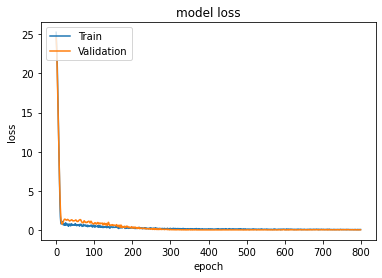

In [16]:
# Without 32 layer
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
# predict homo_level
homo_level_predictions = model.predict(x_test_data)
# predict lumo_level
lumo_level_predictions = pretrained_model(x_test_data)

In [18]:
predictions = model.predict(x_test_data)

In [19]:
# print(homo_level_predictions)
# print(lumo_level_predictions.numpy())

homo_lumo_gap_predictions = lumo_level_predictions.numpy() - homo_level_predictions
print(homo_lumo_gap_predictions)

[[2.0700474]
 [2.1237383]
 [1.8618257]
 ...
 [1.663043 ]
 [2.1140337]
 [1.5342071]]


In [20]:
test_id = test_features["Id"].values
result_data = {"Id": test_id, "y": [gap[0] for gap in homo_lumo_gap_predictions]}
result_pd = pd.DataFrame(result_data)
result_pd.to_csv(result_path, index=False)
print(result_pd)

         Id         y
0     50100  2.070047
1     50101  2.123738
2     50102  1.861826
3     50103  2.497633
4     50104  1.881083
...     ...       ...
9995  60095  2.395138
9996  60096  1.706109
9997  60097  1.663043
9998  60098  2.114034
9999  60099  1.534207

[10000 rows x 2 columns]
